<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/modules/crayfish-mro/Data-Explorer_crayfish-mro.ipynb" target="_blank" rel="noopener noreferrer"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

# Data Explorer

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Part I. Stimulus Processing](#one)
- [Part II. Trial-Based Exploration](#two)
- [Part III. Modeling the MRO Response](#three)

<a id="intro"></a>
# Sensory Coding - MROs

There are two MROs innervating the deep flexor muscles, which can be distinguished based on spike height and shape. 

What are the dynamic properties of MRO sensory responses? In this notebook, you will process, analyze, and model MRO sensory responses.

<a id="setup"></a>
# Setup

[toc](#toc)

Import and define functions

In [1]:
#@title {display-mode: "form" }

#@markdown Run this code cell to import packages and define functions 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.signal import hilbert,medfilt,resample, find_peaks, unit_impulse
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()
import matplotlib.pyplot as plt
import random

from pathlib import Path

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from ipywidgets import widgets, interact, interactive
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

# define any functions
def monoExp(x, m, t, b):
    return m * np.exp(-x/t) + b

def biExp(x, a, k1, b, k2, c):
    return a*np.exp(-x/k1) + b*np.exp(-x/k2) + c

# def RC_filter(R, C, Vpwm, Rpwm, dt):

#     V_out = [Vpwm[0]] # initialize an array of membrane potential across time with the initial membrane potential
    
#     ''' then, we will iterate through time using a "for loop" '''
#     for v_ in Vpwm: # for each time step, iterate through the simulation
#         V = V_out[-1] # what is the current membrane potential?
#         Iapp = v_ / Rpwm
#         dV = (Iapp - (1/R)*V)*(dt/C) # how much does the voltage change by on this time step?
#         V = (V+dV) # add the change in voltage to the current voltage
#         V_out.append(V) # append the new voltage to the array of membrane voltage across time. 
#     V_out = np.asarray(V_out)
#     return V_out # make the array "V_record" available as an output of the scripted function


Task completed at 2022-10-29 13:05:53.049481-05:00


Mount Google Drive

In [ ]:
#@title {display-mode: "form" }

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

## Import data 

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

If you would like sample this Data Explorer, but do not have data, you can download [an example of an increasing step protocol](https://drive.google.com/file/d/1mB2hO60z0HTRsh-IsMOvaCz8YvHGPWoO/view?usp=sharing), [an example of a regular step (variable baseline) protocol](https://drive.google.com/file/d/1B1AdQyUyn-Tu5UAnpxYy9_qodpJzmgPj/view?usp=sharing) and [an example of a continuous bend protocol](https://drive.google.com/file/d/10ZVqZvj8SNA7WEhWmf-yVgn86TqTSJbq/view?usp=sharing). After downloading, you can upload the file directly to Google Colab (or access the file through Drive after uploading it to your Drive). If you are using this example file, the sample rate was 30000 on two channels (channel 0 was the MRO signal and channel 1 was the stimulus monitor). The stimulus is a PWM signal to a servo motor to bend the tail. The recording was taken with the photographed preparation in the lab manual. 

In [3]:
#@title {display-mode: "form" }

#@markdown Specify the file path 
#@markdown to your recorded data on Drive (find the filepath in the colab file manager:

filepath = "full filepath goes here"  #@param 
filepath = '/Volumes/NO NAME/BIOL247_FA22/data/crayfish-mro/KP_20220826/mro_steps_0.bin'  #@param 

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = 30000 #@param
number_channels = 2 #@param

# downsample = False #@param
# newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
# if downsample:
   ## newfs = 10000 #downsample emg data
    # chunksize = int(sampling_rate/newfs)
    # data = data[0::chunksize,:]
    # fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

duration of recording was 301.50 seconds
Data upload completed at 2022-10-29 13:06:24.027852-05:00


## Visualize Data

In [4]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot imported data. <br> 
#@markdown Use the range slider to scroll through the data in time.
#@markdown Use the channel slider to choose which channel to plot
#@markdown Be patient with the range refresh... the more data you are plotting the slower it will be. 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 0.5,
    readout=True,
    continuous_update=False,
    description='Time Range (s)')
slider_xrange.layout.width = '600px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    continuous_update=False,
    description='channel')
slider_chan.layout.width = '300px'

# a function that will modify the xaxis range
def update_plot(x,chan):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    starti = int(x[0]*fs)
    stopi = int(x[1]*fs)
    ax.plot(time[starti:stopi], data[starti:stopi,chan])

w = interact(update_plot, x=slider_xrange, chan=slider_chan);

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), continuous_update=False, description='Time Range (s)'…

For a more extensive ***RAW*** Data Explorer than the one provided in the above figure, use the [DataExplorer.py](https://raw.githubusercontent.com/neurologic/Neurophysiology-Lab/main/howto/Data-Explorer.py) application found in the [howto section](https://neurologic.github.io/Neurophysiology-Lab/howto/Dash-Data-Explorer.html) of the course website.

<a id="one"></a>
# Part I. Stimulus Processing

A servo motor is controlled by a [*pulse width modulated*](https://learn.sparkfun.com/tutorials/pulse-width-modulation/all) (***PWM***) signal. To get a continuous readout of the position command to the servo motor, we need to process the stimulus monitor signal. One way to do this is to *smooth* over the signal with a *filter*. We will use [a gaussian filter from *scipy*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html#scipy.ndimage.gaussian_filter1d) with a standard deviation of 2000 for data with a sample rate of 30kHz. A slightly quicker way would be a square filter, but this generates a noisier signal.

In [5]:
#@title {display-mode: "form"}

#@markdown Indicate which channel has the PWM signal for the stepper motor.

stim_channel = 1 #@param

#@markdown Then, run the code cell to get a smoothed readout 
#@markdown of the average voltage command to the stepper motor across time. <br>
#@markdown NOTE: This processing step takes some time for the computer to accomplish (>10sec). 
#@markdown It also relies on the stimulus monitor having a 5V PWM signal.

'''
# Old way of doing it with gaussian filter

newfs = 10000 #downsample pwm data; 5K should still be enough to get resolution on the smoothed amplitude
signal = data[:,stim_channel]

chunksize = int(sampling_rate/newfs)
signal = signal[0::chunksize]
newfs = int(np.shape(signal)[0]/data_dur)
pwm_time = np.linspace(0,data_dur,np.shape(signal)[0])

w = int(0.25 * newfs)
# pwm = np.convolve(tmp, np.ones(w)/w, mode='full')
pwm = ndimage.gaussian_filter1d(signal,w,axis=0,mode='nearest')
'''

thresh_=3

rawstim = data[:,stim_channel]

# find all places where the signal goes from one side of the threshold to the other
threshold_crossings = np.diff(rawstim > thresh_, prepend=False) 

# get indices where threshold crossings are true
tcross = np.argwhere(threshold_crossings)[:,0]

# get a mask for only positive level crossings
mask_on = [rawstim[t]-rawstim[t-1] > 0 for t in tcross]

# get a mask for only negative level crossings
mask_off = [rawstim[t]-rawstim[t-1] < 0 for t in tcross]

# trial times are positive level crossings
onsets = tcross[mask_on]/fs
offsets = tcross[mask_off]/fs

v_ = medfilt(5*((offsets-onsets)/0.002),21)

vc = np.zeros(len(rawstim))
for i,_ in enumerate(onsets): # for each onset
    
#     j_val = np.min(offsets[offsets>i_val]) # find the next offset
    
#     v_ = (5*((j_val-i_val)/0.002))
    # from this onset until the next onset, set the voltage command value to v_
    if (i+1)<len(onsets):
        # print(int(i_val*fs),int(onsets[i+1]*fs))
        vc[int(onsets[i]*fs):int(onsets[i+1]*fs)]=v_[i]
    if (i+1)==len(onsets):
        vc[int(onsets[i]*fs):-1]=v_[i]

pwm = np.asarray(vc)
# vc = medfilt(vc,41)
# plt.plot(time,medfilt(vc,41))
    

In [6]:
#@title {display-mode: "form"}

#@markdown Run this cell to create an interactive plot with a slider to scroll 
#@markdown through data on each channel for individual trials.
#@markdown The stimulus amplitude will be printed for each trial. 


slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 0.5,
    readout=True,
    continuous_update=False,
    description='Time Range (s)')
slider_xrange.layout.width = '600px'

slider_yrange = widgets.FloatRangeSlider(
    min=np.min(pwm)-0.1,
    max=np.max(pwm)+0.1,
    value=[np.min(pwm),np.max(pwm)],
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange')
slider_yrange.layout.width = '600px'

slider_threshold = widgets.FloatSlider(
    min=np.min(pwm)-0.1,
    max=np.max(pwm)+0.1,
    value=np.mean(pwm),
    step=0.001,
    continuous_update=False,
    readout=True,
    readout_format='.3f',
    description='threshold')
slider_threshold.layout.width = '600px'


# a function that will modify the xaxis range
def update_plot(thresh_,xrange,yrange):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones

    # get the changes in bool value for a bool of signal greater than threshold
    threshold_crossings = np.diff(pwm > thresh_, prepend=False)

    # get indices where threshold crossings are true
    tcross = np.argwhere(threshold_crossings)[:,0]

    # get a mask for only positive level crossings
    mask_ = [pwm[t]-pwm[t-1] > 0 for t in tcross]
    
    # trial times are positive level crossings
    trial_times = tcross[mask_]/fs

    starti = int(xrange[0]*fs)+1
    stopi = int(xrange[1]*fs)-1
    ax.plot(time[starti:stopi], pwm[starti:stopi], color='black')
    
    # ax.plot(tmp,color='black')
    ax.hlines(thresh_, time[starti],time[stopi],linestyle='--',color='green')
    ax.scatter(trial_times,[thresh_]*len(trial_times),marker='^',s=100,color='purple',zorder=3)
    ax.set_ylim(yrange[0],yrange[1])
    ax.set_xlim(xrange[0],xrange[1])
    
#     # Change major ticks to show every 20.
#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     # ax.yaxis.set_major_locator(MultipleLocator(20))

#     # Change minor ticks to show every 5. (20/4 = 5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator(10))
#     ax.yaxis.set_minor_locator(AutoMinorLocator(2))

#     # Turn grid on for both major and minor ticks and style minor slightly
#     # differently.
#     ax.grid(which='major', color='gray', linestyle='-')
#     ax.grid(which='minor', color='gray', linestyle=':')
           
    return trial_times

w_trials_ = interactive(update_plot, thresh_=slider_threshold, xrange=slider_xrange, yrange=slider_yrange);
display(w_trials_)

interactive(children=(FloatSlider(value=4.484438667769835, continuous_update=False, description='threshold', l…

In [7]:
#@title {display-mode: "form"}

#@markdown Run this cell to finalize the list of trial times after settling on a threshold in the interactive plot. <br> 
#@markdown You will then be able to scroll through individual trials to investigate how MRO activity relates to stretch (tail bend).
trial_times = w_trials_.result



<a id="two"></a>
# Part II. Trial-Based Exploration

First you will look at the raw MRO signal aligned to the onset of each trial. You will use an interactive plot to determine a spike threshold detecting putative MRO spikes. 
  > Note that to get more control over visualizing (and/or reproducing) the raw data, I would encourage you to use the DataExplorer.py app instead of the figures of raw data generated here. 

In [8]:
#@title {display-mode: "form"}

#@markdown Indicate which channel has the MRO signal.

mro_channel = 0 #@param

#@markdown Then, run the code cell to set the variable assignment

## MRO Spike Detection

Python has built-in algorithms for detecting "peaks" in a signal. However, it will detect *all* peaks. Therefore, the function takes in arguments that specify parameters for minimum height that can count as a peak and a minimum acceptible interval between independent peaks. 

First, we will detect all the peaks on the MRO nerve channel. This will give the time of each *peak above threshold* (putative MRO spikes).  

In [9]:
#@title {display-mode: "form"}


#@markdown Run this code cell to create an interactive plot with a slider to scroll 
#@markdown through the raw data for individual trials.
#@markdown The processed stimulus signal will be plotted for each trial as well. 
#@markdown Indicate the threshold and the polarity of the threshold: upward (1) or downward (-1) peaks. 
#@markdown Peak times (according to your threshold) will be plotted using green markers.

slider_xrange = widgets.FloatRangeSlider(
    min=-10,
    max=40,
    value=(-2,10),
    step=0.1,
    continuous_update=False,
    readout=True,
    description='xrange (s)'
)
slider_xrange.layout.width = '600px'

slider_yrange_mro = widgets.FloatRangeSlider(
    min=np.min(data[:,mro_channel])-0.1,
    max=np.max(data[:,mro_channel])+0.1,
    value=[np.min(data[:,mro_channel])-0.1,np.max(data[:,mro_channel])+0.1],
    step=0.05,
    continuous_update=False,
    readout=True,
    description='yrange_mro'
)
slider_yrange_mro.layout.width = '600px'

slider_yrange_pwm = widgets.FloatRangeSlider(
    min=np.min(pwm),
    max=np.max(pwm),
    value=[np.min(pwm),np.max(pwm)],
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange_pwm'
)
slider_yrange_pwm.layout.width = '600px'

slider_trial = widgets.IntSlider(
    min=0,
    max=len(trial_times)-1,
    value=0,
    step= 1,
    continuous_update=False,
    readout=True,
    description='trial')
slider_trial.layout.width = '600px'

slider_threshold_low = widgets.FloatSlider(
    min=0,
    max=np.max([np.max(data[:,mro_channel]),np.abs(np.min(data[:,mro_channel]))])+0.1,
    value=0,
    step=0.005,
    continuous_update=False,
    readout=True,
    description='lower threshold')
slider_threshold_low.layout.width = '600px'

slider_threshold_high = widgets.FloatSlider(
    min=0,
    max=np.max([np.max(data[:,mro_channel]),np.abs(np.min(data[:,mro_channel]))])+0.1,
    value=np.max([np.max(data[:,mro_channel]),np.abs(np.min(data[:,mro_channel]))])+0.1,
    step=0.005,
    continuous_update=False,
    readout=True,
    description='upper threshold')
slider_threshold_high.layout.width = '600px'

radio_polarity = widgets.RadioButtons(
    options=[1, -1],
    value=1,
    description='peaks polarity',
    disabled=False
)

# a function that will modify the xaxis range
def update_plot(trial_,xrange,yrange_mro,yrange_pwm,thresh_low_,thresh_high_,polarity):
    fig, ax = plt.subplots(figsize=(10,6),ncols=1, nrows=2,sharex=True,
                           gridspec_kw={'height_ratios':[3, 1]},num=1); #specify figure number so that it does not keep creating new ones
    fig.tight_layout()    
    ax_mro = ax[0]
    ax_pwm = ax[1]
    
    win_0 = int(xrange[0]*fs)
    win_1 = int(xrange[1]*fs)

    t_ = trial_times[trial_]
    if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<np.shape(data)[0]:
        sweep = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),mro_channel] 
        pwm_sweep = pwm[(int(fs*t_)+int(xrange[0]*fs)):(int(fs*t_)+int(xrange[1]*fs))]
    
    xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))

    ax_mro.plot(xtime,sweep,color='black',linewidth=3)
    ax_mro.set_ylim(yrange_mro[0],yrange_mro[1]);
    
    ax_mro.hlines(thresh_low_*polarity, xrange[0],xrange[1],linestyle='--',color='green')
    ax_mro.hlines(thresh_high_*polarity, xrange[0],xrange[1],linestyle='--',color='orange')
    
    
    # calculate spike times based on threshold
    d = 0.0003*fs #minimum time allowed between distinct events
    r = find_peaks(data[:,mro_channel]*polarity,height=thresh_low_,distance=d)

    spike_times = r[0]/fs
    mask_spikes = r[1]['peak_heights']<thresh_high_
    spike_times = spike_times[mask_spikes]

    inwin_spikes = spike_times[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]-t_
    ax_mro.scatter(inwin_spikes,[np.mean(data[:,mro_channel])] * len(inwin_spikes),
          zorder=3,color='green',s=20)
    
    ax_pwm.plot(xtime,pwm_sweep,color='black',linewidth=3)
    ax_pwm.set_xlabel('seconds')
    
    return spike_times
    
#     # Change major ticks to show every 20.
#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     # ax.yaxis.set_major_locator(MultipleLocator(20))

#     # Change minor ticks to show every 5. (20/4 = 5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator(10))
#     ax.yaxis.set_minor_locator(AutoMinorLocator(2))

#     # Turn grid on for both major and minor ticks and style minor slightly
#     # differently.
#     ax.grid(which='major', color='gray', linestyle='-')
#     ax.grid(which='minor', color='gray', linestyle=':')

#     # print(f'stimulus monitor peak = {event_amp[trial_]}')
#     label_eventamp.value = 'peak amplitude = ' + str(np.round(event_amp[trial_],4)) + ' Volts'

w_spikes_ = interactive(update_plot, trial_=slider_trial, xrange=slider_xrange, 
             yrange_mro=slider_yrange_mro,yrange_pwm=slider_yrange_pwm,
             thresh_low_=slider_threshold_low,thresh_high_=slider_threshold_high,polarity=radio_polarity);

display(w_spikes_)

interactive(children=(IntSlider(value=0, continuous_update=False, description='trial', layout=Layout(width='60…

In [10]:
#@title {display-mode: "form"}

#@markdown Run this cell to finalize the list of spike times after settling on a threshold in the interactive plot. <br> 
#@markdown You will then be able to scroll through individual trials to investigate how MRO activity relates to stretch (tail bend).
spike_times = w_spikes_.result



## MRO Spike Rate

In [11]:
#@title {display-mode:"form"}

#@markdown Run this code cell to create an interactive plot with a slider to  
#@markdown examine the spike rate on individual trials. 
#@markdown You can select multiple trials to overlay them by pressing the control/command key while selecting
#@markdown The processed stimulus signal will be plotted for each trial as well. 

slider_xrange = widgets.FloatRangeSlider(
    min=-10,
    max=40,
    value=(-2,10),
    step=0.05,
    continuous_update=False,
    readout=True,
    description='xrange (s)'
)
slider_xrange.layout.width = '600px'

slider_yrange_mro = widgets.FloatRangeSlider(
    min=-5,
    max=np.nanmax(1/np.diff(spike_times,prepend=np.NaN))+10, # max spike rate
    value=(-5,np.nanmax(1/np.diff(spike_times,prepend=np.NaN))+10),
    step=0.05,
    continuous_update=False,
    readout=True,
    description='yrange_mro'
)
slider_yrange_mro.layout.width = '600px'

slider_yrange_pwm = widgets.FloatRangeSlider(
    min=np.min(pwm),
    max=np.max(pwm)+0.1,
    value=[np.min(pwm),np.max(pwm)+0.1],
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange_stim'
)
slider_yrange_pwm.layout.width = '600px'

select_trials = widgets.SelectMultiple(
    options=np.arange(len(trial_times)),
    value=[0],
    #rows=10,
    description='Trials',
    disabled=False
)


def update_plot(trial_list,xrange,yrange_mro,yrange_pwm):
    fig, ax = plt.subplots(figsize=(10,6),ncols=1, nrows=2,sharex=True,
                           gridspec_kw={'height_ratios':[3, 1]},num=1); #specify figure number so that it does not keep creating new ones
    fig.tight_layout()
    ax_mro = ax[0]
    ax_pwm = ax[1]
    
    win_0 = int(xrange[0]*fs)
    win_1 = int(xrange[1]*fs)
    xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))
    
    spk_rate = 1/np.diff(spike_times,prepend=np.NaN)

    for trial_ in trial_list:
        t_ = trial_times[trial_]

        
        if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<np.shape(data)[0]:
            # sweep = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),mro_channel] 
            pwm_sweep = pwm[(int(fs*t_)+int(xrange[0]*fs)):(int(fs*t_)+int(xrange[1]*fs))]
            
            ax_pwm.plot(xtime,pwm_sweep,color='black',linewidth=3,alpha=0.25)

        xs = spike_times[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]-t_
        ys = spk_rate[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]
        ax_mro.scatter(xs,ys,color='black',s=50,alpha=0.25)
    
    ax_mro.set_xlim(xrange[0],xrange[1])
    ax_mro.set_ylim(yrange_mro[0],yrange_mro[1]);
    
    ax_pwm.set_xlabel('seconds')
    ax_pwm.set_xlim(xrange[0],xrange[1])
    ax_pwm.set_ylim(yrange_pwm[0],yrange_pwm[1]);
    
#     # Change major ticks to show every 20.
    # ax_pwm.xaxis.set_major_locator(MultipleLocator(5))
    # ax_pwm.yaxis.set_major_locator(MultipleLocator(5))

    # Change minor ticks to show every 5. (20/4 = 5)
    ax_mro.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax_mro.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax_pwm.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # Turn grid on for both major and minor ticks and style minor slightly
#     # differently.
    ax_mro.grid(which='major', color='gray', linestyle='-')
    ax_mro.grid(which='minor', color='gray', linestyle=':')
    ax_pwm.grid(which='major', color='gray', linestyle='-')
    ax_pwm.grid(which='minor', color='gray', linestyle=':')


w = interact(update_plot, trial_list=select_trials, xrange=slider_xrange, 
             yrange_mro=slider_yrange_mro,yrange_pwm=slider_yrange_pwm);
# display(w)

interactive(children=(SelectMultiple(description='Trials', index=(0,), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, …

<a id="three"></a>
# Part III. Modeling the MRO response

You can create a ***model*** of the MRO response. If the model is correct, you should be able to 'explain' the response in terms of the model (it should be able to predict all features of the response).

The following code cells provide a tool to model the response using a single exponential function of the form:

$$
\Large y = a + b*e^{-x/\tau}
$$

For spiking adaptation, the following equation variables are more intuitive:

$$
\Large R_{t} = R_{\infty} + R_{0}e^{−t/\tau}
$$

Where $R_{t}$ is the firing rate at time $t$, $R_{\infty}$ is the calculated firing rate if this degree of stretch were maintained infinitely, $R_{\infty}$ + $R_{0}$ is the calculated “initial” peak firing rate at time 0, and $\tau$ is the adaptation rate. The adaptation rate is the time it takes the spike rate to fall by a factor of $1/e$.

To model the MRO response in this form, you will *fit* your data to the model. 

In biology / electrophysiology *bi*exponential functions are often used to separate fast and slow components of exponential decay which may be caused by different mechanisms and occur at different rates. In this example we will only fit the data to a method with a exponential component (a *mono*exponential function), but the idea is the same.

## Fitting an exponential model

There is likely *across trial* variability in the MRO response. You can get a model fit for each trial and then evaluate the distrubution of model parameters. Alternatively, you could take the average response across trials and fit the model to the average. Here, you will do the former. What are the pros and cons of each of these methods in terms of statistical results? In other words, are the two methods equivalent or can you calculate different metrics of statistics depending on the method? 

In [32]:
#@title {display-mode:"form"}

#@markdown Indicate which channel has the MRO signal.
mro_channel = 0 #@param

#@markdown Then, run this code cell to create an interactive plot with a slider to  
#@markdown examine the spike rate on individual trials. 
#@markdown You can select multiple trials to overlay them by pressing the control/command key while selecting
#@markdown The processed stimulus signal will be plotted for each trial as well. 
#@markdown Use the checkbox to toggle on/off an exponential fit.
#@markdown Before fitting the data, make sure the time range starts at the peak of the spike rate 
#@markdown and ends at the end of the steady state response.
#@markdown When you fit the data, the mean and stnadard deviation of model parameters 
#@markdown across selected trials will be printed, including a measure of fit (Rsquared).

slider_xrange = widgets.FloatRangeSlider(
    min=-0.5,
    max=40,
    value=(-2,10),
    step=0.05,
    continuous_update=False,
    readout=True,
    description='xrange (s)'
)
slider_xrange.layout.width = '600px'

slider_yrange_mro = widgets.FloatRangeSlider(
    min=-5,
    max=np.nanmax(1/np.diff(spike_times,prepend=np.NaN))+10, # max spike rate
    value=(-5,np.nanmax(1/np.diff(spike_times,prepend=np.NaN))+10),
    step=0.05,
    continuous_update=False,
    readout=True,
    description='yrange_mro'
)
slider_yrange_mro.layout.width = '600px'

slider_yrange_pwm = widgets.FloatRangeSlider(
    min=np.min(pwm),
    max=np.max(pwm)+0.1,
    value=[np.min(pwm),np.max(pwm)+0.1],
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange_stim'
)
slider_yrange_pwm.layout.width = '600px'

select_trials = widgets.SelectMultiple(
    options=np.arange(len(trial_times)),
    value=[0],
    #rows=10,
    description='Trials',
    disabled=False
)


check_do_fit = widgets.Checkbox(
    value=False,
    description='Do Exponential Fit',
    disabled=False
)

radio_fit_type = widgets.RadioButtons(
    options=['mono', 'bi'],
    value='bi',
    description='fit type',
    disabled=False
)

label_stimamp = widgets.Label(
    value='Median stimulus signal within this window = (need to select trials)'
)
label_stimamp.layout.width = '600px'
display(label_stimamp)

label_fit_u = widgets.Label(
    value='Exponential Fit = (need to fit trials)'
)
label_fit_u.layout.width = '600px'
display(label_fit_u)

# label_fit_s = widgets.Label(
#     value='Exponential Fit std = (need to select trials)'
# )
# label_fit_s.layout.width = '600px'
# display(label_fit_s)

def update_plot(trial_list,xrange,yrange_mro,yrange_pwm,fit_type,do_fit):
    fig, ax = plt.subplots(figsize=(10,5),ncols=1, nrows=2,sharex=True,
                           gridspec_kw={'height_ratios':[3, 1]},num=1); #specify figure number so that it does not keep creating new ones
    fig.tight_layout()
    ax_mro = ax[0]
    ax_pwm = ax[1]
    
    win_0 = int(xrange[0]*fs)
    win_1 = int(xrange[1]*fs)
    xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))
    
    spk_rate = 1/np.diff(spike_times,prepend=np.NaN)

    for trial_ in trial_list:
        t_ = trial_times[trial_]
        
        if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<np.shape(data)[0]:
            # sweep = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),mro_channel] 
            pwm_sweep = pwm[(int(fs*t_)+win_0):(int(fs*t_)+win_1)]
            pwm_amp = np.median(pwm_sweep)
            label_stimamp.value = f'Median stimulus signal within this window = {pwm_amp:0.3f}'
            
            ax_pwm.plot(xtime,pwm_sweep,color='black',linewidth=3,alpha=0.25)

        xs = spike_times[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]-t_
        ys = spk_rate[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]
        ax_mro.scatter(xs,ys,color='black',s=50,alpha=0.25)
        
    y_fit = []
    params = []
    u_fit = std_fit = [np.NaN]*4
    m = t = b = np.NaN
    if do_fit:
        # perform the fit
        if len(trial_list)==0:
            u_fit = std_fit = [np.NaN]*4
            label_fit_u.value = f"mean m = {u_fit[0]:.2f}, tau = {u_fit[1]:.2f}, b = {u_fit[2]:.2f}, Rsquared = {u_fit[3]:.2f}"
            # label_fit_s.value = f"std m = {std_fit[0]:.2f}, tau = {std_fit[1]:.2f}, b = {std_fit[2]:.2f}, Rsquared = {std_fit[3]:.2f}"

        if len(trial_list)>0:
            for trial_ in trial_list:
                t_ = trial_times[trial_]

                xs = spike_times[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]-t_
                ys = spk_rate[(spike_times>(t_+xrange[0])) & (spike_times<(t_+xrange[1]))]

                offset=np.min(xs)
                xs = xs-offset # offset so that x starts at 0 for fit

                if fit_type=='bi':#bi fit
                    p0 = [5, 0.5,15, 4, np.min(ys)] # start with values near those we expect
                    param_bounds=((0,0,0,0,0),(200,10,200,10,200))
                    params_, cv = curve_fit(biExp, xs, ys,p0,bounds=param_bounds,maxfev = 5000) #(x, a, k1, b, k2, c)
                    a, k1, b, k2, c = params_
                    y_fit = biExp(xs, a, k1, b, k2, c)#+np.min(ys)
                
                if fit_type=='mono': #mono fit
                    p0 = [10, 2, np.min(ys)] # start with values near those we expect
                    params_, cv = curve_fit(monoExp, xs, ys,p0,maxfev = 5000) #monoexponential
                    m, t, c = params_
                    y_fit = monoExp(xs, m, t, c)#+np.min(ys)
                
                

                squaredDiffs = np.square(ys - y_fit)
                squaredDiffsFromMean = np.square(ys - np.mean(ys))
                rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)

                params_ = np.concatenate([params_, [rSquared]])
                params.extend(params_)

                xs = xs+offset # reset x positions for scatter now that fit

                ax_mro.plot(xs,y_fit,color='green',linestyle='--',linewidth=3,zorder=3)

            if fit_type=='mono':
                fit_parameters = np.asarray(params).reshape(-1,4)
                u_fit = np.nanmean(fit_parameters,0)
                std_fit = np.nanstd(fit_parameters,0)

                label_fit_u.value = f"m = {u_fit[0]:.2f}, tau = {u_fit[1]:.2f}, c = {u_fit[2]:.2f}, Rsquared = {u_fit[3]:.2f}"
                # label_fit_s.value = f"std m = {std_fit[0]:.2f}, tau = {std_fit[1]:.2f}, c = {std_fit[2]:.2f}, Rsquared = {std_fit[3]:.2f}"
                
            if fit_type=='bi': #a, k1, b, k2, c
                fit_parameters = np.asarray(params).reshape(-1,6)
                u_fit = np.nanmean(fit_parameters,0)
                std_fit = np.nanstd(fit_parameters,0)

                label_fit_u.value = f"m1 = {u_fit[0]:.2f}, tau1 = {u_fit[1]:.2f}, m2 = {u_fit[2]:.2f}, tau2 = {u_fit[3]:.2f}, c = {u_fit[4]:.2f}, Rsquared = {u_fit[5]:.2f}"
                # label_fit_s.value = f"std m = {std_fit[0]:.2f}, tau = {std_fit[1]:.2f}, b = {std_fit[2]:.2f}, Rsquared = {std_fit[3]:.2f}"
        
    ax_mro.set_xlim(xrange[0],xrange[1])
    ax_mro.set_ylim(yrange_mro[0],yrange_mro[1]);
    
    ax_pwm.set_xlabel('seconds')
    ax_pwm.set_xlim(xrange[0],xrange[1])
    ax_pwm.set_ylim(yrange_pwm[0],yrange_pwm[1]);
    
#     # Change major ticks to show every 20.
    # ax_pwm.xaxis.set_major_locator(MultipleLocator(5))
    # ax_pwm.yaxis.set_major_locator(MultipleLocator(5))

    # Change minor ticks to show every 5. (20/4 = 5)
    ax_mro.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax_mro.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax_pwm.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # Turn grid on for both major and minor ticks and style minor slightly
#     # differently.
    ax_mro.grid(which='major', color='gray', linestyle='-')
    ax_mro.grid(which='minor', color='gray', linestyle=':')
    ax_pwm.grid(which='major', color='gray', linestyle='-')
    ax_pwm.grid(which='minor', color='gray', linestyle=':')


w = interact(update_plot, trial_list=select_trials, xrange=slider_xrange, 
             yrange_mro=slider_yrange_mro,yrange_pwm=slider_yrange_pwm,fit_type=radio_fit_type, do_fit=check_do_fit);
# display(w)

Label(value='Median stimulus signal within this window = (need to select trials)', layout=Layout(width='600px'…

Label(value='Exponential Fit = (need to fit trials)', layout=Layout(width='600px'))

interactive(children=(SelectMultiple(description='Trials', index=(0,), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, …

## Generate model data

Now, use the mean parameters to generate model data of your results.
For multiple conditions, list multiple values for each parameter. Keep the order of conditions the same in each list.

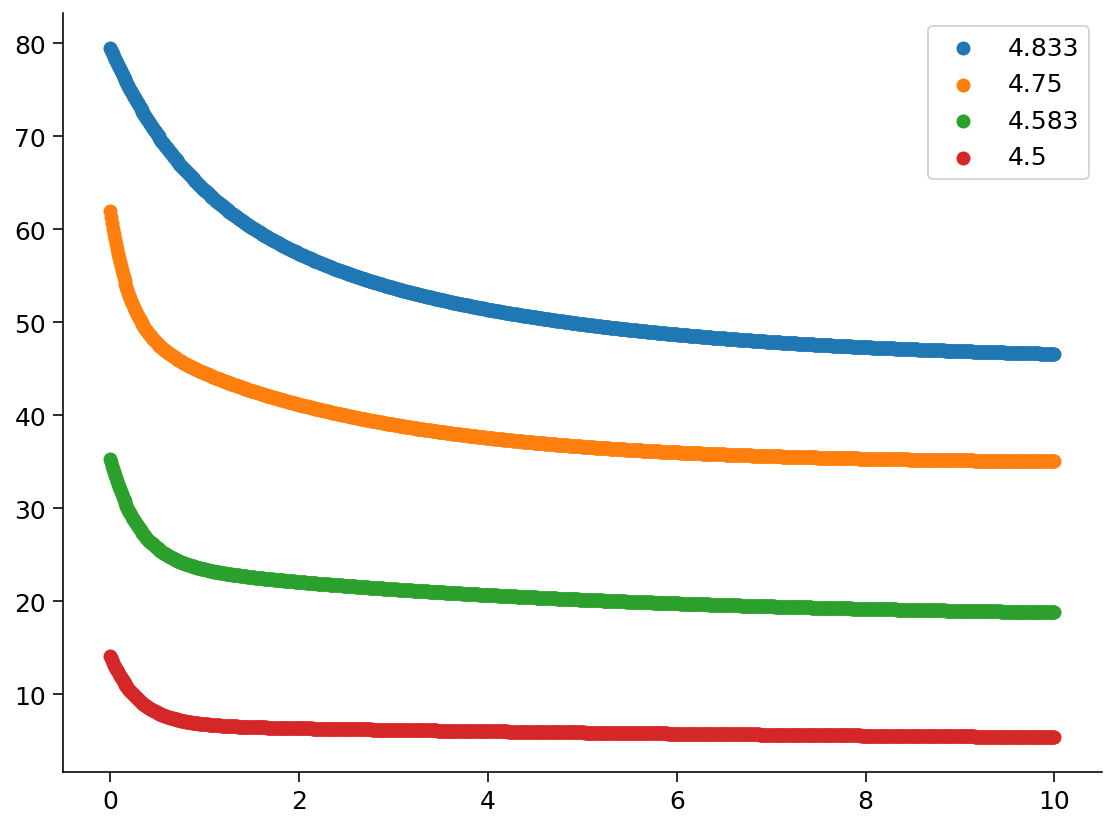

In [36]:
#@title {display-mode:"form"} Bi-Exponential Fit

#@markdown Create a list of conditions (the stimulus amplitude during the stretch)
condition = [4.833,4.75,4.583,4.5] #@param

#@markdown Create a list of fit model parameters across conditions.
m1 = [13.8,12.6,11.1,7.4] #@param
tau1 = [0.8,0.2,0.3,0.3] #@param
m2 = [19.9,14.6,6.1,2.1] #@param
tau2 = [3.1,2.4,4.6,10] #@param
c = [45.8,34.8,18.1,4.6] #@param
r_squared = [0.99,0.99,0.89,0.58]#@param

#@markdown How long do you want the model MRO to be stretched for under each condition?
trial_dur = 10 #@param

# Run this code cell to plot the model across conditions
fig,ax = plt.subplots()

x_ = np.linspace(0,trial_dur,trial_dur*100)

for m1_,tau1_,m2_,tau2_,c_,l_ in zip(m1,tau1,m2,tau2,c,condition):
    y_ = biExp(x_, m1_,tau1_,m2_,tau2_,c_)
    ax.scatter(x_, y_, label = str(l_))

plt.legend()


## Plot processed data from csv

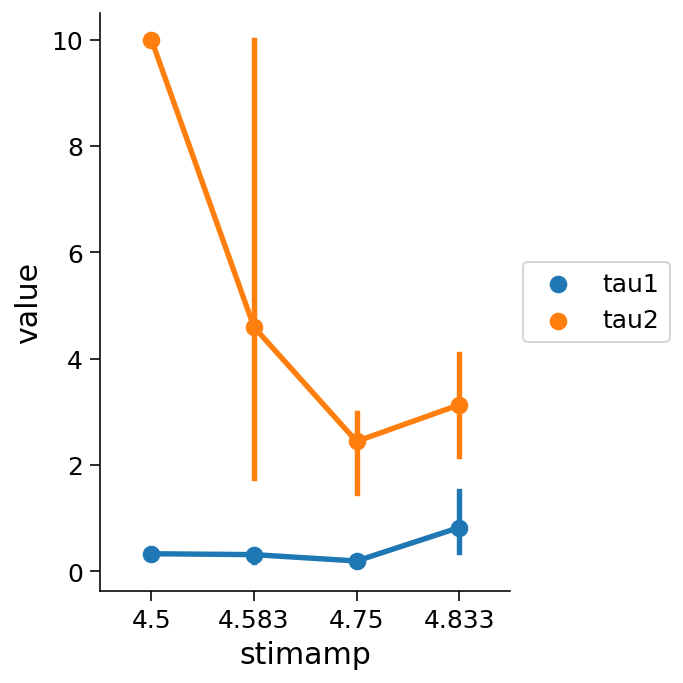

In [78]:
#@title {display-mode:"form"}

#@markdown Specify the filepath to a csv file
filepath = 'filepath to csv' #@param
filepath = '/Users/kperks/Documents/Teaching/Neurophysiology-Lab/modules/crayfish-mro/progressive-step-results.csv'

#@markdown Specify the header name of the column you want for your x points. 
#@markdown If more than one header is specified (separated by commas), each will be plotted overlaid in a different color for a violin plot.
x_column = ['column header(s) for x axis'] #@param
x_column = ['stimamp']

# #@markdown Specify categorical bins using np.arange(start,stop,step) if the x_column is a continuous variable. 
# #@markdown Use empty brackets if not needed.
# categorical_bins = np.arange(0,25,0.5) #@param

#@markdown Specify the header name of the column you want for your y points. 
#@markdown If more than one header is specified (separated by commas), each will be plotted overlaid in a different color for a scatter plot
y_column = ['column header(s) for y axis'] #@param
# y_column = ['m1','m2','c']
y_column = ['tau1','tau2']

# #@markdown Specify the plot type ('scatter' or 'violin'). Note that for a 'violin' plot, only the 'x_column' data would be used.
# plot_type = 'plot type' #@param

plot_type = 'point'

# #@markdown Specify the x-axis range for the plot
# x_lim = [0,10] #@param


df = pd.read_csv(filepath)

hfig,ax = plt.subplots(figsize=(5,5))

if plot_type == 'scatter':
    df_melted = df[y_column+x_column].melt(x_column[0],var_name='headers')
    g = sns.scatterplot(data=df_melted,x=x_column[0],y='value',hue='headers',alpha=0.75);
            
if plot_type == 'point':
    df_melted = df[y_column+x_column].melt(x_column[0],var_name='headers')
    
#     if len(categorical_bins)>0:
#         df_melted[x_column[0]] = pd.cut(df_melted[x_column[0]],bins=categorical_bins,labels=categorical_bins[1:])
        
    g = sns.pointplot(data=df_melted,x=x_column[0],y='value',hue='headers',alpha=0.75);

        
if plot_type == 'violin':
  # sns.stripplot(y=y_column,data=df,color='black',size=10);
    if len(x_column)==1:
        g = sns.violinplot(x=x_column[0],data=df,color='grey')
    if len(x_column)>1:
        df_melted = df[x_column].dropna().melt(var_name='headers')
        g = sns.violinplot(x='value',y='headers',split=True,data=df_melted, inner="stick")
        
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
# ax.set_xlim(x_lim[0],x_lim[1])


## Inspect relationships among average model parameters

Plot the model parameters as a function of stretch. Is there some predictable relationship between these?
Which parameters are a function of specific stretch amplitudes? Which parameters are independent of the specific stretch amplitude? In other words, which properties of the MRO response code for position of the tail and which code for other aspects of the movement?

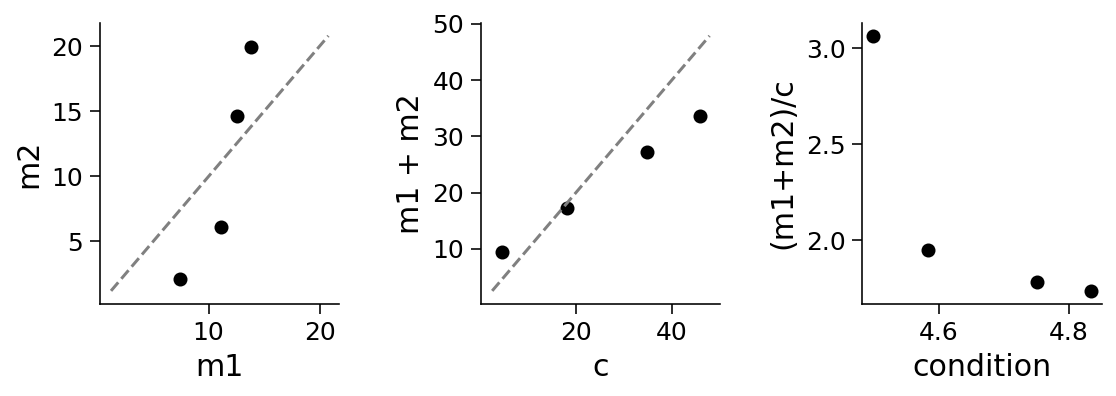

In [77]:
#@title {display-mode:"form"}

#@markdown Run this code cell to plot scatterplots of model parameter relationships.

hfig,ax = plt.subplots(1,3,figsize=(8,3))
ax[0].scatter(m1,m2,color='black')
ax[0].set_xlabel('m1')
ax[0].set_ylabel('m2')
minunity = np.min([ax[0].get_xlim()]+[ax[0].get_ylim()])
maxunity = np.max([ax[0].get_xlim()]+[ax[0].get_ylim()])
ax[0].plot([minunity,maxunity],[minunity,maxunity],color = 'gray',linestyle='--')

ax[1].scatter(c,[sum(_) for _ in zip(m1,m2)],color='black')
minunity = np.min([ax[1].get_xlim()]+[ax[1].get_ylim()])
maxunity = np.max([ax[1].get_xlim()]+[ax[1].get_ylim()])
ax[1].plot([minunity,maxunity],[minunity,maxunity],color = 'gray',linestyle='--')
ax[1].set_xlabel('c')
ax[1].set_ylabel('m1 + m2')

ax[2].scatter(condition,[sum(_)/_[2] for _ in zip(m1,m2,c)],color='black');
ax[2].set_xlabel('condition')
ax[2].set_ylabel('(m1+m2)/c');


<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.

<a id="setup"></a>

<a id="one"></a>

<a id="two"></a>

<a id="three"></a>

<a id="four"></a>